In [53]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__, ' ', tf.keras.__version__)

2.10.0   2.10.0


In [54]:
from tensorflow.keras.datasets import reuters

```num_words``` restricts data to 10,000 most frequently occuring words

In [55]:
(train_data, train_labels,), (test_data, test_labels) = reuters.load_data(num_words=10000)

print(len(train_data), len(test_data))

8982 2246


Each example is a list of integers (word indices):


In [56]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

### Decode Examples back into words

In [57]:
def decode_wire(data):
    word_index = reuters.get_word_index()

    reverse_word_index = dict([(value, key) for (key,value) in word_index.items()])

    # indices offset by 3 bc 0,1,2 rerserved indices for "padding", "start of sequence", and "unknown"
    decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in data])

    return decoded_review

Label associated with an example is integer [0,45] => topic index

# 4.2.2 Preparing the Data
Can vectorize the data - 2 options:
1. Cast label list as integer tensor
    - **note:** if chose to encode labels using integer tensor => would need to select ```sparse_categorical_crossentorpy```
2. One-hot Encoding
    - **note:** if chose to encode labels using integer tensor => would need to select ```categorical_crossentorpy```


In [58]:
import numpy as np

### Vectorize data

In [59]:
def vectorize_sequences(sequences, dimension = 10000):
    results = np.zeros((len(sequences), dimension))

    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# def vectorize_sequences(sequences, dimension = 10000):
#     results = np.zeros((len(sequences), dimension))
#     for i, sequence in enumerate(sequences):
#         results[i, sequence] = 1.
#     return results

In [60]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)



### One-Hot Encode Labels

In [61]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1
    return results

#### Bulit in one-hot encoding from keras

In [62]:
#one hot encoder for lists
from tensorflow.keras.utils import to_categorical 

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

# 4.2.3 Build Model Network
Similar to IMDB but now output classes has increased from 2 to 46  
Dimensionality of output much larger  
Used a 16 dim rep space for intermediate imdb layer but might be too small to seperate 46 different classes
=> **Infomation Bottleneck** 

With stack of dense layers, each layer only has access to information presented from previous layer  
If layer drops some relevant information, info not recoverd by later layers   

Use larger layers in this case = 64 units

**Last layer**
- 46 units output
- ```softmax``` activation
    - probability distribution over the 46 different output classes
    - ```output[i]``` = prob that sample blongs to class ```i```




In [63]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential([
    layers.Dense(64, activation = 'relu', input_shape = (10000,)),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(46, activation = 'softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                640064    
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 46)                2990      
                                                                 
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


Model Summary shows output shape of each layer and number of trainable params
- Number of params in the w and b layer tensors
Length of zero'th axis (sample axis) is zero as usual

**Shape of Weight and bias Tensors by layer**


In [64]:
# The weight and bias tensors
def print_layer_tensor_shape(layer):
    weight_params = model.layers[layer].get_weights()[0]
    bias_params = model.layers[layer].get_weights()[1]
    print(layer, '\t', 'Weight Params: ', weight_params.shape, '\t', 'Bias Param: ', bias_params.shape)

print_layer_tensor_shape(layer=0)
print_layer_tensor_shape(layer=1)
print_layer_tensor_shape(layer=2)

0 	 Weight Params:  (10000, 64) 	 Bias Param:  (64,)
1 	 Weight Params:  (64, 64) 	 Bias Param:  (64,)
2 	 Weight Params:  (64, 46) 	 Bias Param:  (46,)


Weight tensor has shape (n,m) (n rows, m cols).  
n*m elements  
bias tensor just a vector: number of elements = length  
Total trainable parameters = total number of elements in all w and b tensors

In [65]:
(10000 * 64 + 64) + (64 * 64 + 64) + (64 * 46 + 46)

647214



**Loss Function**  
```categorical_crossentropy```: measures the distance between 2 probability distributions
- probability distribution output by the model
- true distribution of the labels

**note:** if chose to encode labels using integer tensor => would need to select ```sparse_categorical_crossentorpy```

```rmsprop``` optimizer selected again

In [66]:
model.compile(optimizer = 'rmsprop',
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])

# 4.2.4 Validating Approach

Set apart 1000 samples in training data for validation

In [67]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]


Train models for 20 epochs  
Mini-batch 512  

In [68]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 40ms/step - loss: 2.6172 - accuracy: 0.5331 - val_loss: 1.7502 - val_accuracy: 0.6460
Epoch 2/20
16/16 [==============================] - 0s 25ms/step - loss: 1.4269 - accuracy: 0.7015 - val_loss: 1.3120 - val_accuracy: 0.7170
Epoch 3/20
16/16 [==============================] - 0s 30ms/step - loss: 1.0621 - accuracy: 0.7732 - val_loss: 1.1357 - val_accuracy: 0.7510
Epoch 4/20
16/16 [==============================] - 0s 29ms/step - loss: 0.8407 - accuracy: 0.8216 - val_loss: 1.0321 - val_accuracy: 0.7890
Epoch 5/20
16/16 [==============================] - 0s 28ms/step - loss: 0.6743 - accuracy: 0.8588 - val_loss: 0.9933 - val_accuracy: 0.7900
Epoch 6/20
16/16 [==============================] - 0s 28ms/step - loss: 0.5458 - accuracy: 0.8877 - val_loss: 0.9298 - val_accuracy: 0.8130
Epoch 7/20
16/16 [==============================] - 0s 25ms/step - loss: 0.4368 - accuracy: 0.9119 - val_loss: 0.9020 - val_accuracy: 0.8210
Epoch 8/20
16

Show loss and accuracy curves

In [70]:
def plot_epochs(x, 
                    y_A, style_A, label_A, 
                    y_B, style_B, label_B, 
                    title, x_label, y_label):
    
    import matplotlib.pyplot as plt
    plt.clf()
    plt.plot(x, y_A, style_A, label = label_A)
    plt.plot(x, y_B, style_B, label = label_B)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()
    
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']  

Drawing code packed inside ```plot-epochs```

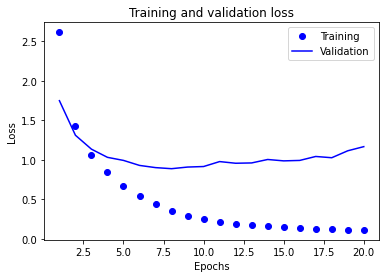

In [71]:
plot_epochs(range(1, len(loss) + 1), 
            loss, 'bo', 'Training',
            val_loss, 'b', 'Validation',
            'Training and validation loss',
            'Epochs',
            'Loss')

### Training and Validation Loss

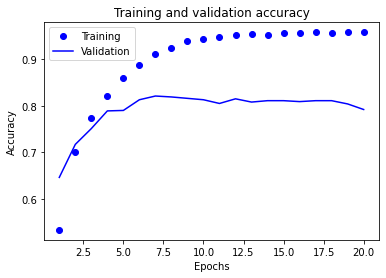

In [72]:
plot_epochs(range(1, len(loss) + 1), 
            acc, 'bo', 'Training',
            val_acc, 'b', 'Validation',
            'Training and validation accuracy',
            'Epochs',
            'Accuracy')

Model begins to overfit after 6 epochs

## Retrain model from scratch using 6 epochs

In [73]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

model.compile(optimizer="rmsprop",
            loss="categorical_crossentropy",
            metrics=["accuracy"])

model.fit(
    x_train, y_train,
    epochs=9,
    batch_size=512)

results = model.evaluate(x_test, y_test)

Epoch 1/9
18/18 [==============================] - 1s 27ms/step - loss: 2.5116 - accuracy: 0.5390
Epoch 2/9
18/18 [==============================] - 1s 31ms/step - loss: 1.3360 - accuracy: 0.7164
Epoch 3/9
18/18 [==============================] - 1s 28ms/step - loss: 0.9892 - accuracy: 0.7861
Epoch 4/9
18/18 [==============================] - 1s 34ms/step - loss: 0.7764 - accuracy: 0.8324
Epoch 5/9
18/18 [==============================] - 0s 27ms/step - loss: 0.6201 - accuracy: 0.8683
Epoch 6/9
18/18 [==============================] - 1s 31ms/step - loss: 0.4938 - accuracy: 0.8962
Epoch 7/9
18/18 [==============================] - 0s 25ms/step - loss: 0.4010 - accuracy: 0.9138
Epoch 8/9
18/18 [==============================] - 0s 26ms/step - loss: 0.3268 - accuracy: 0.9310
Epoch 9/9
71/71 [==============================] - 0s 2ms/step - loss: 0.9767 - accuracy: 0.7867


In [74]:
results

[0.9766589999198914, 0.7867319583892822]

Reaches accuracy of close to 80%.  In a balanced binary classifier random guessing would achieve 50%.  
In multi-class have 46 classes here so default accuracy much lower.  Random baseline model would achieve around 19% from textbook.

# 4.2.5 Predictions 
calling models ```predict``` method on new samples returns a class probability distribution over all 46 topics  

Generate predictions for all test data:

In [76]:
predictions = model.predict(x_test)

# each entry is vector of length 46
print(predictions[0].shape)

#coefficients in vector sum to 1 (prob dist
print(np.sum(predictions[0]))

# largest entry = predicted class (highest prob)
print(np.argmax(predictions[0]))

71/71 [==============================] - 0s 2ms/step
(46,)
1.0000001
3


In [77]:
print('wire', '\t', 'pred', '\t', 'label')
for i in range(10):
    print(i, '\t', np.argmax(predictions[i]), '\t', test_labels[i]) 

wire 	 pred 	 label
0 	 3 	 3
1 	 10 	 10
2 	 1 	 1
3 	 16 	 4
4 	 13 	 4
5 	 3 	 3
6 	 3 	 3
7 	 3 	 3
8 	 3 	 3
9 	 3 	 3


### Importance of sufficiently large intermediate layers
Experiment with what happens choosing layers with fewer than 46 units  
Get Information Bottleneck


In [79]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
])

model.compile(optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

history_compressed = model.fit(partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 4s 48ms/step - loss: 3.0853 - accuracy: 0.2316 - val_loss: 2.4068 - val_accuracy: 0.3770
Epoch 2/20
63/63 [==============================] - 1s 14ms/step - loss: 1.9449 - accuracy: 0.5472 - val_loss: 1.7235 - val_accuracy: 0.5960
Epoch 3/20
63/63 [==============================] - 1s 15ms/step - loss: 1.5262 - accuracy: 0.6180 - val_loss: 1.5600 - val_accuracy: 0.6120
Epoch 4/20
63/63 [==============================] - 1s 16ms/step - loss: 1.3469 - accuracy: 0.6358 - val_loss: 1.5016 - val_accuracy: 0.6230
Epoch 5/20
63/63 [==============================] - 1s 13ms/step - loss: 1.2334 - accuracy: 0.6644 - val_loss: 1.4817 - val_accuracy: 0.6500
Epoch 6/20
63/63 [==============================] - 1s 13ms/step - loss: 1.1495 - accuracy: 0.6908 - val_loss: 1.4511 - val_accuracy: 0.6540
Epoch 7/20
63/63 [==============================] - 1s 12ms/step - loss: 1.0643 - accuracy: 0.7045 - val_loss: 1.4366 - val_accuracy: 0.6670
Epoch 8/20
63

In [80]:
loss_compressed = history_compressed.history['loss']
val_loss_compressed = history_compressed.history['val_loss']
acc_compressed = history_compressed.history['accuracy']
val_acc_compressed = history_compressed.history['val_accuracy']  

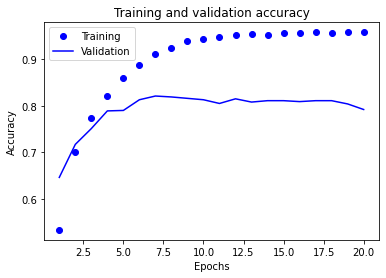

In [81]:
plot_epochs(range(1, len(loss) + 1), 
            acc, 'bo', 'Training',
            val_acc, 'b', 'Validation',
            'Training and validation accuracy',
            'Epochs',
            'Accuracy')